# A hopefully simple tutorial on Active inference for continuous PO-MDPs
_______
By Jesus Cevallos


## Why we need Markov Decision Processes

Imagine an agent — a robot, an animal, or even a thermostat — that interacts with an environment over time.  
At each moment:

- The environment has **some state**, describing what is going on.
- The agent takes **an action**.
- The environment changes in response.
- The agent receives **feedback** (in reinforcement learning) or *perceptions* (in active inference).

To reason about such interactions, we need a mathematical model that:

- Represents how the world evolves over time  
- Represents how the agent influences the world  
- Allows us to compute or infer how good (or *expected*) different action sequences are  

The simplest such model is a **Markov Decision Process (MDP)**.

## What is a Markov Decision Process?

An MDP is defined by:

$$
\mathcal{M} = (\mathcal{S},\mathcal{A},P(s_{t+1}\mid s_t, a_t), R(s_t,a_t))
$$

Where:

- **$\mathcal{S}$** is the set of possible *states* of the world  
- **$\mathcal{A}$** is the set of possible *actions* the agent can take  
- **$P(s_{t+1} \mid s_t, a_t)$** is the probability of the next state  
- **$R(s_t,a_t)$** (only in RL) is a reward function  

### The Markov Property

The key assumption that makes MDPs simple and powerful is:

$$
\text{The future depends only on the present, not on the whole past.}
$$

Formally:

$$
P(s_{t+1} \mid s_{0:t}, a_{0:t}) = P(s_{t+1} \mid s_t, a_t).
$$

This is a *memorylessness* assumption.  
The idea is: **the present state summarizes all relevant information about the past**.

This dramatically simplifies computations.

Without the Markov assumption, state prediction would require the entire history, which is computationally explosive.


## The Graphical (Causal) Structure of an MDP

An MDP can be expressed as a causal diagram (run cell bellow):

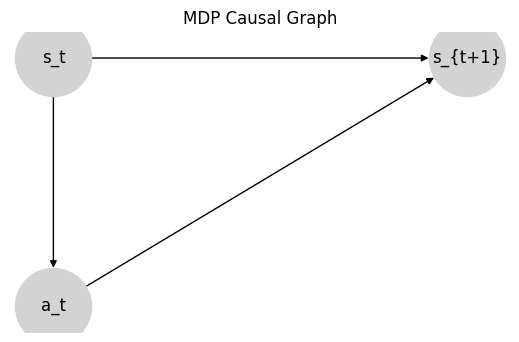

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_nodes_from(["s_t", "a_t", "s_{t+1}"])

G.add_edges_from([
    ("s_t", "a_t"),        # Policy depends on state
    ("s_t", "s_{t+1}"),    # Transition depends on state
    ("a_t", "s_{t+1}")     # Transition also depends on action
])

pos = {
    "s_t": (0, 1),
    "a_t": (0, 0),
    "s_{t+1}": (2, 1)
}

plt.figure(figsize=(5,3))
nx.draw(G, pos, with_labels=True, node_color="lightgray", node_size=3000)
plt.title("MDP Causal Graph")
plt.show()

Where the arrows mean “causes” or “influences”.

More explicitly:

- The state at time $t$ causes the next state  
- The action also contributes causally  

MDPs are called **fully observable** because states are supposed to be visible.

## Why MDPs Are Not Enough

MDPs assume the agent *sees* the world’s true state $s_t$.

But in real life:

* A robot only sees sensor readings
* A human only perceives noisy sensory data
* A self-driving car sees camera images, not true distances
* A rat navigating a maze does not know which room it is in with certainty

In all realistic situations, the agent receives **uncertain** or **indirect** information about the true state.

This motivates **Partially Observed MDPs (POMDPs)**.

## From MDPs to POMDPs: The Need for Hidden States

In a POMDP, the agent receives **observations**:

* $o_t$ is what the agent *observes*
* $s_t$ is the true (hidden) state
* There is a mapping (likelihood model)
  $$
  P(o_t \mid s_t)
  $$

This makes the problem **much more realistic**, because it models:

* sensor noise
* perceptual ambiguity
* incomplete information
* uncertainty about what is happening


## Formal Structure of a POMDP

A POMDP is:

$$
\mathcal{P} = (\mathcal{S}, \mathcal{A}, \mathcal{O},
P(s_{t+1}\mid s_t,a_t), P(o_t\mid s_t))
$$

Differences from MDP:

* Observations $o_t$ are noisy functions of hidden states
* Agent must **infer** states from observations
* This leads to beliefs, filtering, and Bayesian inference

In other words, we go from:

MDP:
**State is known → choose action**

POMDP:
**State is unknown → infer hidden state → choose action**


## 7. The Causal Graph of a POMDP

A POMDP can be visualized running the cell below:

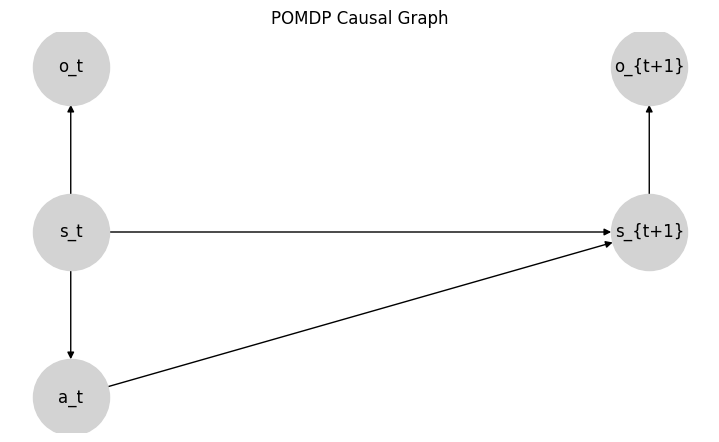

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

nodes = ["s_t", "a_t", "s_{t+1}", "o_t", "o_{t+1}"]
G.add_nodes_from(nodes)

edges = [
    ("s_t", "a_t"),          
    ("s_t", "o_t"),          
    ("s_t", "s_{t+1}"),      
    ("a_t", "s_{t+1}"),      
    ("s_{t+1}", "o_{t+1}")   
]

G.add_edges_from(edges)

pos = {
    "s_t": (0, 1),
    "a_t": (0, 0),
    "o_t": (0, 2),
    "s_{t+1}": (2, 1),
    "o_{t+1}": (2, 2)
}

plt.figure(figsize=(7,4))
nx.draw(G, pos, with_labels=True, node_color="lightgray", node_size=3000)
plt.title("POMDP Causal Graph")
plt.show()

* Hidden states cause observations
* Hidden states evolve based on actions

This structure is **exactly** the generative model used in active inference.



## Conditional Independences in POMDPs

The heart of the POMDP structure is the **conditional independence** that hidden states enforce:

### Observations depend only on the current hidden state

$$
 P(o_t \mid s_t, a_{t-1}, s_{t-1}, o_{t-1}, \ldots) = P(o_t \mid s_t)
$$

Meaning:

> Once you know the current hidden state, the observation no longer depends on the past. (Note that observations are also independent of previous actions given states...)

This is a **causal shielding** property.

### State transitions depend only on current state and action

$$
P(s_{t+1} \mid s_t, a_t, s_{t-1}, o_{t-1}, \ldots) = P(s_{t+1} \mid s_t, a_t)
$$

The hidden state encodes all relevant information for prediction. (We do not care about previous observations either)

### The Generative Process vs. The Generative Model

Up to this point, we've described the **generative process**: the actual, external dynamics of the world as modeled by a POMDP. This is the "true" mechanism by which hidden states evolve, actions influence those states, and observations are generated. In the generative process, we use probabilities denoted by $P$, such as $P(s_{t+1} \mid s_t, a_t)$ for state transitions and $P(o_t \mid s_t)$ for the likelihood of observations given states.

However, the agent (e.g., a robot or animal) does not have direct access to this true process. Instead, the agent maintains an internal **generative model**: a probabilistic representation of how it *believes* the world works. This model allows the agent to infer hidden states from observations, predict future outcomes, and plan actions. The generative model is "specular" (mirror-like) to the generative process—it has a similar structure—but it represents the agent's subjective beliefs, which may approximate or diverge from the true process.

In active inference, we denote the distributions in the generative model with $Q$ to distinguish them from the true $P$ distributions of the process. For example:
- $Q(s_{t+1} \mid s_t, a_t)$ approximates the state transition.
- $Q(o_t \mid s_t)$ approximates the observation likelihood.

The key difference:
- **Generative Process ($P$)**: The objective, external world dynamics (often unknown to the agent).
- **Generative Model ($Q$)**: The agent's internal, subjective model used for inference and decision-making. It is learned or updated over time to better match the process.

### Factorization Under the Markovian Assumption

Under the Markovian assumption (as in the POMDP structure), the generative model factorizes according to the conditional independencies in the causal graph. This means the joint probability breaks down into simpler, local conditional distributions, making computations tractable.

Recall the POMDP causal structure: Hidden states evolve based on previous states and actions, and observations depend only on the current hidden state. Actions are chosen based on inferred states (via a policy, which we'll discuss later).

The factorization of the generative model is:
$$
Q(s_{0:T}, a_{0:T-1}, o_{0:T}) = Q(s_0) \prod_{t=0}^{T-1} Q(s_{t+1} \mid s_t, a_t) \cdot Q(a_t \mid s_t) \cdot \prod_{t=0}^{T} Q(o_t \mid s_t)
$$

Breaking it down:
- $Q(s_0)$: Prior belief over the initial hidden state.
- $Q(s_{t+1} \mid s_t, a_t)$: Believed state transition model (Markovian: depends only on current state and action).
- $Q(a_t \mid s_t)$: The agent's policy, specifying actions given inferred states.
- $Q(o_t \mid s_t)$: Likelihood model (observations depend only on the current hidden state).

This factorization mirrors the generative process but uses $Q$ to reflect the agent's approximate beliefs. The Markovian property ensures that each term depends only on immediate predecessors, "shielding" the future from the distant past.

### Model Inversion: Inferring Hidden States via Bayes' Theorem

Once the agent has initialized its **generative model** $Q(s_{0:T}, a_{0:T-1}, o_{0:T})$, its primary task is to **invert** this model to infer the hidden states that best explain the observed data. This inversion is the core of perception in active inference and is performed using **Bayes' theorem**.

Let:
- $\underline{o} \triangleq o_{0:\tau-1}$: the sequence of past observations up to time $\tau-1$,
- $\underline{a} \triangleq a_{0:\tau-1}$: the sequence of past actions,
- $\underline{s} \triangleq s_{0:\tau}$: the full sequence of hidden states (including current time $\tau$).

The agent wants to compute the **posterior belief** over the current hidden state $s_\tau$ (denoted $s_t$ for current time) given all past observations and actions:
$$
Q(s_t \mid \underline{o}, \underline{a})
$$

This posterior represents the agent's **inferred belief** about the current state of the world.

### Bayesian Model Inversion

Using Bayes' theorem in the generative model:

$$
\boxed{
Q(s_t \mid \underline{o}, \underline{a}) 
= \frac{Q(\underline{o} \mid \underline{a}, \underline{s}) \cdot Q(\underline{s} \mid \underline{a})}{Q(\underline{o} \mid \underline{a})}
}
$$

This is **exact Bayesian inference** within the agent's internal model:
- $Q(\underline{o} \mid \underline{a}, \underline{s})$: **Likelihood** — how well a state sequence explains the observations (via $Q(o_t \mid s_t)$).
- $Q(\underline{s} \mid \underline{a})$: **Prior** — the predicted state trajectory under the agent's transition model and past actions.
- $Q(\underline{o} \mid \underline{a})$: **Model evidence** (marginal likelihood) — normalizes the posterior.



### Exploiting Conditional Independence (Markov Structure)

Thanks to the **Markovian assumptions** in the generative model, many terms become conditionally independent. In particular:
- Each observation $o_t$ depends **only** on its contemporaneous state $s_t$,
- Each state transition $s_{t+1}$ depends **only** on $s_t$ and $a_t$.

This allows us to simplify the likelihood:
$$
Q(\underline{o} \mid \underline{a}, \underline{s}) = Q(\underline{o} \mid \underline{s}) = \prod_{k=0}^{\tau-1} Q(o_k \mid s_k)
$$

So the full posterior becomes:

$$
\boxed{
Q(s_t \mid \underline{o}, \underline{a}) 
= \frac{
\overbrace{Q(\underline{o} \mid \underline{s})}^{\text{likelihood over all obs}}
\cdot 
\overbrace{Q(\underline{s} \mid \underline{a})}^{\text{prior state trajectory}}
}{
Q(\underline{o} \mid \underline{a})
}
}
$$

This is still a **joint inference** over the entire state sequence $\underline{s}$, which is computationally expensive for long sequences.


### Recursive Belief Updating

In practice, the agent does **not** re-infer the entire past on every step. Instead, it maintains a **belief state** (a sufficient statistic) and updates it recursively — this is **Bayesian filtering**.

At each time step, the agent:
1. Predicts the next state using its transition model: $Q(s_{t} \mid s_{t-1}, a_{t-1})$,
2. Receives observation $o_t$,
3. Updates belief using Bayes: $Q(s_t \mid o_t, \text{past}) \propto Q(o_t \mid s_t) \cdot Q(s_t \mid \text{past})$, where $Q(s_t \mid \text{past})$ is approximated using the $Q(s_{t} \mid s_{t-1}, a_{t-1})$ previously computed.

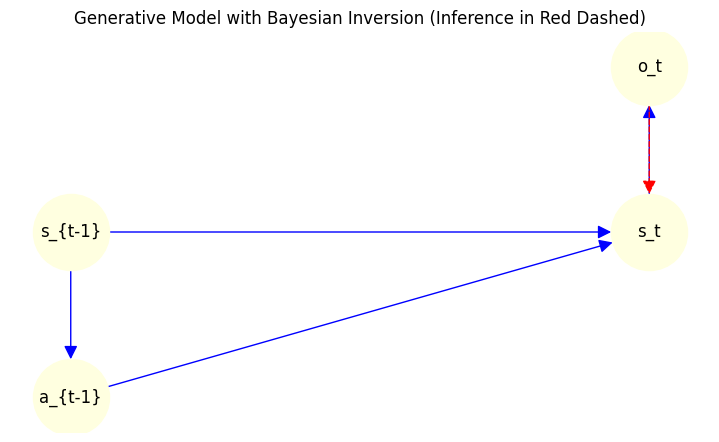

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Nodes
nodes = ["s_{t-1}", "a_{t-1}", "s_t", "o_t"]
G.add_nodes_from(nodes)

# Generative (causal) edges
gen_edges = [
    ("s_{t-1}", "a_{t-1}"),
    ("s_{t-1}", "s_t"),
    ("a_{t-1}", "s_t"),
    ("s_t", "o_t")
]
G.add_edges_from(gen_edges, color='blue', style='solid', label='Generative')

# Inference (recognition) edges
inf_edges = [
    ("o_t", "s_t")
]
G.add_edges_from(inf_edges, color='red', style='dashed', arrowstyle='->', label='Inference')

pos = {
    "s_{t-1}": (0, 1),
    "a_{t-1}": (0, 0),
    "s_t": (2, 1),
    "o_t": (2, 2)
}

plt.figure(figsize=(7, 4))
edges = G.edges()
colors = [G[u][v].get('color', 'black') for u,v in edges]
styles = [G[u][v].get('style', 'solid') for u,v in edges]

nx.draw(G, pos, with_labels=True, node_color="lightyellow", node_size=3000,
        edge_color=colors, style=styles, arrowsize=20)

plt.title("Generative Model with Bayesian Inversion (Inference in Red Dashed)")
plt.axis('off')
plt.show()

- **Solid blue arrows**: Generative dependencies ($Q$ forward model).
- **Dashed red arrow**: Inference — "explaining away" observations by inferring hidden states.

This inversion is the foundation of **perception**. In the next section, we’ll see that exact inversion is intractable for rich models, leading to **variational approximations** via **Free Energy**.

### Approximating the Posterior

Recall the three steps in **recursive belief updating**:
1. Predict the next state using the transition model,
2. Receive a new observation,
3. Update the belief via Bayes' rule.

A critical question arises: **how do we compute the model evidence** $Q(\underline{o} \mid \underline{a})$?

This term is the **marginal likelihood** of the observations under the agent’s generative model. Formally:

$$
Q(\underline{o} \mid \underline{a}) = \int Q(\underline{o}, \underline{s} \mid \underline{a}) \, d\underline{s}
= \int \underbrace{Q(\underline{o} \mid \underline{s})}_{\text{likelihood}} \cdot \underbrace{Q(\underline{s} \mid \underline{a})}_{\text{prior over trajectories}} \, d\underline{s}
$$

This is a **high-dimensional integral** over all possible state sequences $\underline{s} = s_{0:\tau}$. For even moderately long sequences or continuous state spaces, this integral is **intractable** — it cannot be computed exactly.

Thus, **exact Bayesian inference** is generally infeasible in real-time agents.

## The Evidence Lower BOund (ELBO)

The evidence monster turns out to be lower bounded by a tractable approximation. Its about using **Jensen’s inequality** on the concave $\log$ function. We derive a **lower bound** on the **log model evidence**:

Start from:

$$
Q(\underline{o} \mid \underline{a}) = \int Q(\underline{o}, \underline{s} \mid \underline{a}) \, d\underline{s}
$$

### The Variational Trick: Introducing an Approximation

Notice the distribution $Q(\underline{s}|\underline{a})$ is precisely the one that rates the likelihood of a trajectory of states $\underline{s}$ given a trajectory of actions $\underline{a}$.

To try to approximately compute $Q(\underline{o} \mid \underline{a})$ to be able to do model inversion, we introduce a **variational distribution** of states $q(\underline{s}|\underline{a})$ — this is a simpler, factorized, or parameterized distribution that we can compute.

We restrict $q(\underline{s}|\underline{a})$ to a family of distributions that are easy to evaluate and update (e.g., mean-field, Gaussian, recurrent neural network approximations).

By doing so, we can introduce such a distribution in the previous integral and try to express the evidence as an expectation over our variational distribution:

$$
Q(\underline{o} \mid \underline{a}) = \int Q(\underline{o}, \underline{s} \mid \underline{a}) \,\frac{q(\underline{s}|\underline{a})}{q(\underline{s}|\underline{a})} d\underline{s}
$$

Then we use the definition of expectation:

$$
Q(\underline{o} \mid \underline{a}) = \mathbb{E}_{q(\underline{s}|\underline{a})}\left[ \frac{Q(\underline{o}, \underline{s} \mid \underline{a})}{q(\underline{s}|\underline{a})} \right]
$$

Let's apply the logarithm to both sides of the equation:

$$
\ln Q(\underline{o} \mid \underline{a}) = \ln \mathbb{E}_{q(\underline{s}|\underline{a})}\left[\frac{Q(\underline{o}, \underline{s} \mid \underline{a})}{q(\underline{s}|\underline{a})} \right]
$$

And then notice that, by Jensen's inequality, we get:


$$
\ln Q(\underline{o} \mid \underline{a}) 
\geq \mathbb{E}_{q(\underline{s}|\underline{a})} \left[ \ln \frac{Q(\underline{o}, \underline{s} \mid \underline{a})}{q(\underline{s}|\underline{a})} \right]
$$

Which can be expressed as follows (remember the properties of logarithms and the definition of entropy):


$$
\ln Q(\underline{o} \mid \underline{a}) 
\geq \underbrace{\mathbb{E}_{q(\underline{s}|\underline{a})} \left[ \ln Q(\underline{o}, \underline{s} \mid \underline{a}) \right]}_{\text{Expected joint log-likelihood}} + \mathbb{H}\left[ q(\underline{s}\mid \underline{a}) \right]
$$